In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy import optimize
import matplotlib.pyplot as plt
import pymc3 as pm
#from numpy.random import seed
from IPython.core.pylabtools import figsize
import seaborn as sns
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

import warnings
warnings.filterwarnings('ignore')
sns.set()

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\kisha\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
C:\Users\kisha\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
hourlydf = pd.read_csv(r'C:\Users\kisha\Documents\Springboard Data Science\Capstone Project 1\Datasets Italia\Telecommunications - SMS, Call, Internet - MI\Hourly-Consolidated-cellid_day.txt',delimiter='\t')

In [3]:
hourlydf.iloc[::100000]

,cellId,timeIntervalts,timeInterval,SMSin,SMSout,callIn,callOut,internet,SMS,call
0,1,2013-11-01 00:00:00+01:00,8299571400000,2.084285,1.104749,0.591930,0.429290,57.799009,3.189034,1.021221
100000,71,2013-12-07 16:00:00+01:00,8318579400000,5.439302,4.080989,3.566774,4.921197,91.608034,9.520291,8.487971
200000,142,2013-11-16 14:00:00+01:00,8307649800000,5.043325,15.496752,4.778215,4.045091,66.746060,20.540077,8.823306
300000,212,2013-12-24 11:00:00+01:00,8327284200000,5.949796,2.324965,4.349472,4.894890,23.199024,8.274761,9.244362
400000,283,2013-12-02 03:00:00+01:00,8315706600000,0.091614,0.022904,0.000000,0.000000,5.001055,0.114518,0.000000
...,...,...,...,...,...,...,...,...,...,...
13700000,9677,2013-12-16 10:00:00+01:00,8323115400000,51.853791,18.978159,54.413618,65.294730,795.214537,70.831950,119.708347
13800000,9748,2013-11-24 02:00:00+01:00,8311537800000,1.590960,0.504737,0.105154,0.450351,295.781672,2.095697,0.555504
13900000,9819,2013-11-01 18:00:00+01:00,8299960200000,16.091510,7.017818,7.930460,11.230761,176.906108,23.109328,19.161220
14000000,9889,2013-12-08 10:00:00+01:00,8318968200000,10.059605,4.418877,14.930013,13.730482,391.924098,14.478482,28.660495


In [4]:
hourlydf['timeIntervalts'] = pd.to_datetime(hourlydf['timeIntervalts'])
hourlydf['hour'] = hourlydf['timeIntervalts'].dt.hour
hourlydf['day'] = hourlydf['timeIntervalts'].dt.day_name()
hourlydf['daynum'] = hourlydf.timeIntervalts.dt.dayofweek
hourlydf = hourlydf.set_index('timeIntervalts')
hourlydf.iloc[::100000]

,cellId,timeInterval,SMSin,SMSout,callIn,callOut,internet,SMS,call,hour,day,daynum
timeIntervalts,,,,,,,,,,,,
2013-11-01 00:00:00+01:00,1,8299571400000,2.084285,1.104749,0.591930,0.429290,57.799009,3.189034,1.021221,0,Friday,4
2013-12-07 16:00:00+01:00,71,8318579400000,5.439302,4.080989,3.566774,4.921197,91.608034,9.520291,8.487971,16,Saturday,5
2013-11-16 14:00:00+01:00,142,8307649800000,5.043325,15.496752,4.778215,4.045091,66.746060,20.540077,8.823306,14,Saturday,5
2013-12-24 11:00:00+01:00,212,8327284200000,5.949796,2.324965,4.349472,4.894890,23.199024,8.274761,9.244362,11,Tuesday,1
2013-12-02 03:00:00+01:00,283,8315706600000,0.091614,0.022904,0.000000,0.000000,5.001055,0.114518,0.000000,3,Monday,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-16 10:00:00+01:00,9677,8323115400000,51.853791,18.978159,54.413618,65.294730,795.214537,70.831950,119.708347,10,Monday,0
2013-11-24 02:00:00+01:00,9748,8311537800000,1.590960,0.504737,0.105154,0.450351,295.781672,2.095697,0.555504,2,Sunday,6
2013-11-01 18:00:00+01:00,9819,8299960200000,16.091510,7.017818,7.930460,11.230761,176.906108,23.109328,19.161220,18,Friday,4


In [7]:
corr = hourlydf.corr()
corr

,cellId,timeInterval,SMSin,SMSout,callIn,callOut,internet,SMS,call,hour,daynum
cellId,1.000000e+00,0.007631,0.112164,0.116567,0.108976,0.112156,0.134833,0.116509,0.111267,-0.000010,6.518275e-07
timeInterval,7.631219e-03,1.000000,0.006383,0.005931,0.005796,0.005967,0.004533,0.006379,0.005919,0.015814,-6.039595e-04
SMSin,1.121641e-01,0.006383,1.000000,0.895334,0.960479,0.953618,0.895376,0.987198,0.962082,0.157236,-6.499313e-02
SMSout,1.165667e-01,0.005931,0.895334,1.000000,0.842331,0.835209,0.843780,0.954913,0.843148,0.154450,-5.595979e-02
callIn,1.089758e-01,0.005796,0.960479,0.842331,1.000000,0.978196,0.852959,0.941873,0.993854,0.158884,-8.585931e-02
callOut,1.121556e-01,0.005967,0.953618,0.835209,0.978196,1.000000,0.836540,0.934749,0.995174,0.158620,-8.177292e-02
internet,1.348332e-01,0.004533,0.895376,0.843780,0.852959,0.836540,1.000000,0.898997,0.848878,0.107061,-3.659518e-02
SMS,1.165089e-01,0.006379,0.987198,0.954913,0.941873,0.934749,0.898997,1.000000,0.943234,0.160119,-6.336219e-02
call,1.112674e-01,0.005919,0.962082,0.843148,0.993854,0.995174,0.848878,0.943234,1.000000,0.159614,-8.415138e-02
hour,-9.977353e-06,0.015814,0.157236,0.154450,0.158884,0.158620,0.107061,0.160119,0.159614,1.000000,4.986068e-06


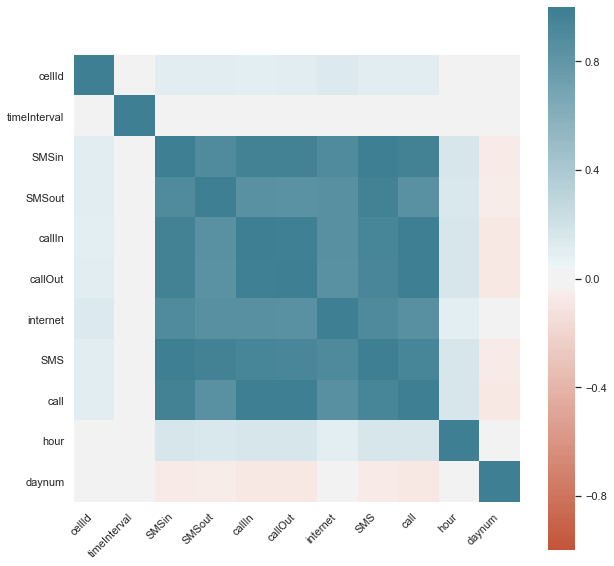

In [8]:
plt.figure(figsize(10,10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [11]:
corr1 = hourlydf[['SMSin','SMSout','callIn','callOut','internet']].corr()
corr1

,SMSin,SMSout,callIn,callOut,internet
SMSin,1.000000,0.895334,0.960479,0.953618,0.895376
SMSout,0.895334,1.000000,0.842331,0.835209,0.843780
callIn,0.960479,0.842331,1.000000,0.978196,0.852959
callOut,0.953618,0.835209,0.978196,1.000000,0.836540
internet,0.895376,0.843780,0.852959,0.836540,1.000000


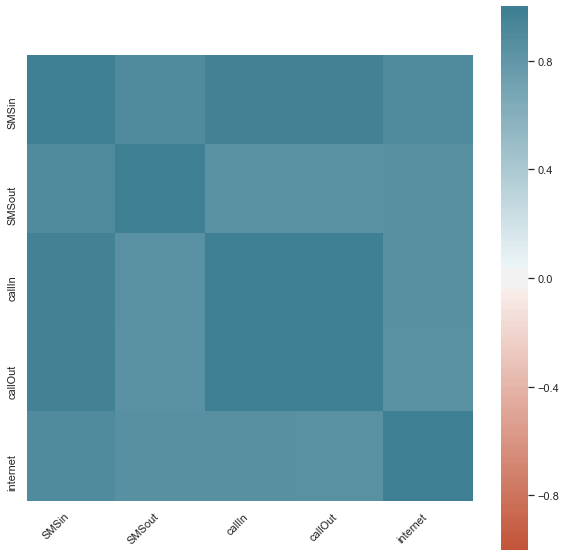

In [12]:
plt.figure(figsize(10,10))
ax = sns.heatmap(
    corr1, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [12]:
for i in [1,2,24,168]:
    print('lag = '+str(i)+' hrs SMS auto correlation is ' + str(hourlydf['SMS'].autocorr(lag=i)))
for i in [1,2,24,168]:
    print('lag = '+str(i)+' hrs call auto correlation is ' + str(hourlydf['call'].autocorr(lag=i)))
for i in [1,2,24,168]:
    print('lag = '+str(i)+' hrs internet auto correlation is ' + str(hourlydf['internet'].autocorr(lag=i)))


lag = 1 hrs SMS auto correlation is 0.9590042514701889
lag = 2 hrs SMS auto correlation is 0.8940868900873471
lag = 24 hrs SMS auto correlation is 0.9064699477973678
lag = 168 hrs SMS auto correlation is 0.8945711393619599
lag = 1 hrs call auto correlation is 0.9654173910850429
lag = 2 hrs call auto correlation is 0.8901350086975313
lag = 24 hrs call auto correlation is 0.9154217571774697
lag = 168 hrs call auto correlation is 0.9132183392189821
lag = 1 hrs internet auto correlation is 0.9821365888522948
lag = 2 hrs internet auto correlation is 0.9497953836523055
lag = 24 hrs internet auto correlation is 0.9470411443626819
lag = 168 hrs internet auto correlation is 0.9142671844527529


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

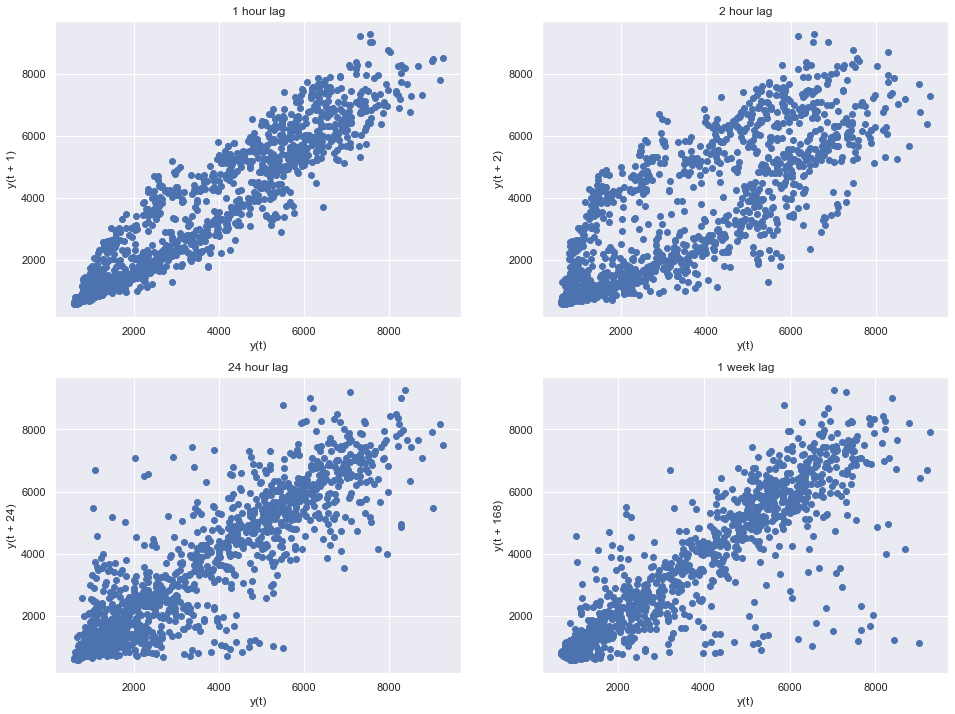

In [15]:
# lag_plot for internet on one cell 5060
plt.figure(figsize=(16,12))
plt.subplot(221)
pd.plotting.lag_plot(hourlydf[hourlydf.cellId==5060].reset_index()['internet'],lag=1)
plt.title('1 hour lag')
plt.subplot(222)
pd.plotting.lag_plot(hourlydf[hourlydf.cellId==5060].reset_index()['internet'],lag=2)
plt.title('2 hour lag')
plt.subplot(223)
pd.plotting.lag_plot(hourlydf[hourlydf.cellId==5060].reset_index()['internet'],lag=24)
plt.title('24 hour lag')
plt.subplot(224)
pd.plotting.lag_plot(hourlydf[hourlydf.cellId==5060].reset_index()['internet'],lag=168)
plt.title('1 week lag')
plt.show()

In [38]:
#SMS hourly plot
fig = px.line(hourlydf[hourlydf.cellId==5060].reset_index(), x='timeIntervalts'
              , y='SMS', title='Weekly Sesonality', hover_data=['day'])
fig.update_xaxes(rangeslider_visible=True)
fig.show()
#call hourly plot
fig = px.line(hourlydf[hourlydf.cellId==5060].reset_index(), x='timeIntervalts'
              , y='call', title='Call', hover_data=['day'])
fig.update_xaxes(rangeslider_visible=True)
fig.show()
#Internet hourly plot
fig = px.line(hourlydf[hourlydf.cellId==5060].reset_index(), x='timeIntervalts'
              , y='internet', title='Internet', hover_data=['day'])
fig.update_xaxes(rangeslider_visible=True)

fig.show()

In [57]:
#create a sine function with a period of 24 hours
def sin_func(x, a, b, c):
    return a * np.sin(2*np.pi*(1/24)* x +b) + c

In [58]:
x_data = hourlydf[hourlydf.cellId==5060].reset_index().index
y_data = hourlydf[hourlydf.cellId==5060]['SMS']
params, params_covariance = optimize.curve_fit(sin_func, x_data, y_data(#,p0=[750, 2,500])
print(params)

[-591.47320253    1.00647232  506.37233919]


In [59]:
y_fit = sin_func(x_data,*params)

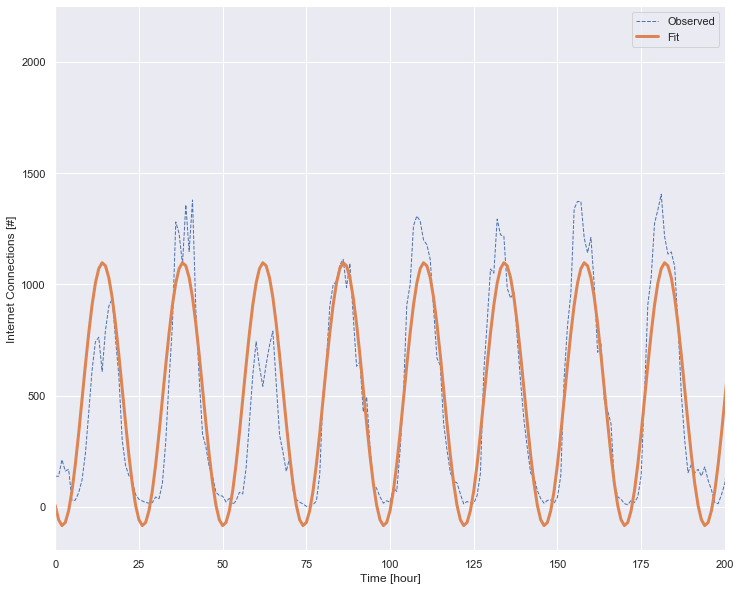

In [107]:
f = plt.figure(figsize=(12,10))
plt.plot(x_data, y_data, linewidth=1, linestyle='--', label='Observed')
plt.plot(x_data, y_fit, linewidth=3, label='Fit')
plt.xlabel("Time [hour]")
plt.ylabel("Internet Connections [#]")
plt.xlim(0,200)
plt.legend()
sns.despine()
plt.show()

In [80]:
x_data = hourlydf[hourlydf.cellId==5060].reset_index().index.values
x_data

array([   0,    1,    2, ..., 1413, 1414, 1415], dtype=int64)

In [97]:
import pymc3 as pm
import theano.tensor as tt
with pm.Model() as model:
    a = pm.Normal("a", mu=params[0], sd=10)
    b = pm.Normal("b", mu=params[1], sd=10)
    c = pm.Normal("c", mu=params[2], sd=10)
    std = pm.Uniform("std", 0, 100)
    
    #ydata = f(xdata, *params) + eps.
    mean = pm.Deterministic("mean", a * tt.sin(2*np.pi*(1/24)* x_data +b) + c)

    obs = pm.Normal("obs", mu=mean, sd=std, observed=y_data)

    trace = pm.sample(100000, step=pm.Metropolis())
    burned_trace = trace[20000:]

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [std]
>Metropolis: [c]
>Metropolis: [b]
>Metropolis: [a]


Sampling 2 chains for 1_000 tune and 100_000 draw iterations (2_000 + 200_000 draws total) took 969 seconds.
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023915386648>,
      dtype=object)

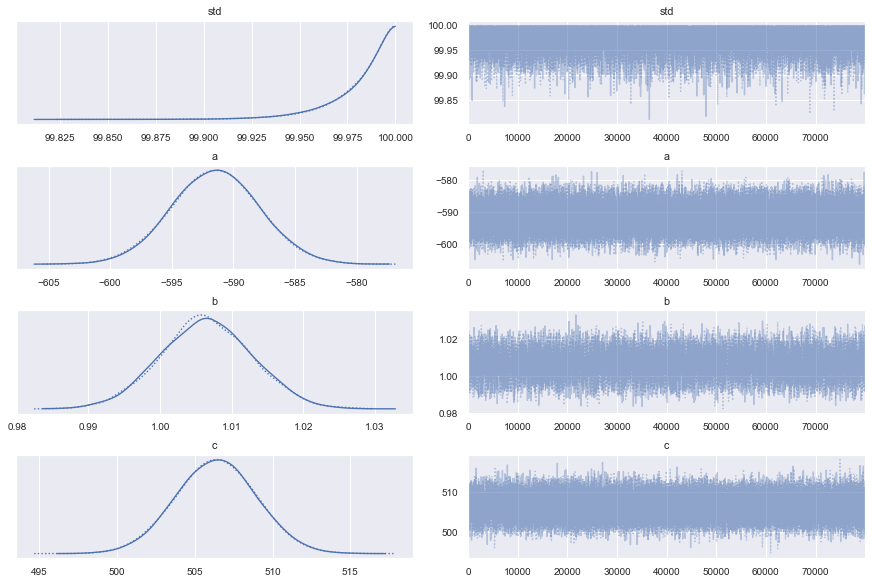

In [98]:
pm.plots.traceplot(burned_trace, varnames=["std", "a", "b",'c'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002391530EC88>,
      dtype=object)

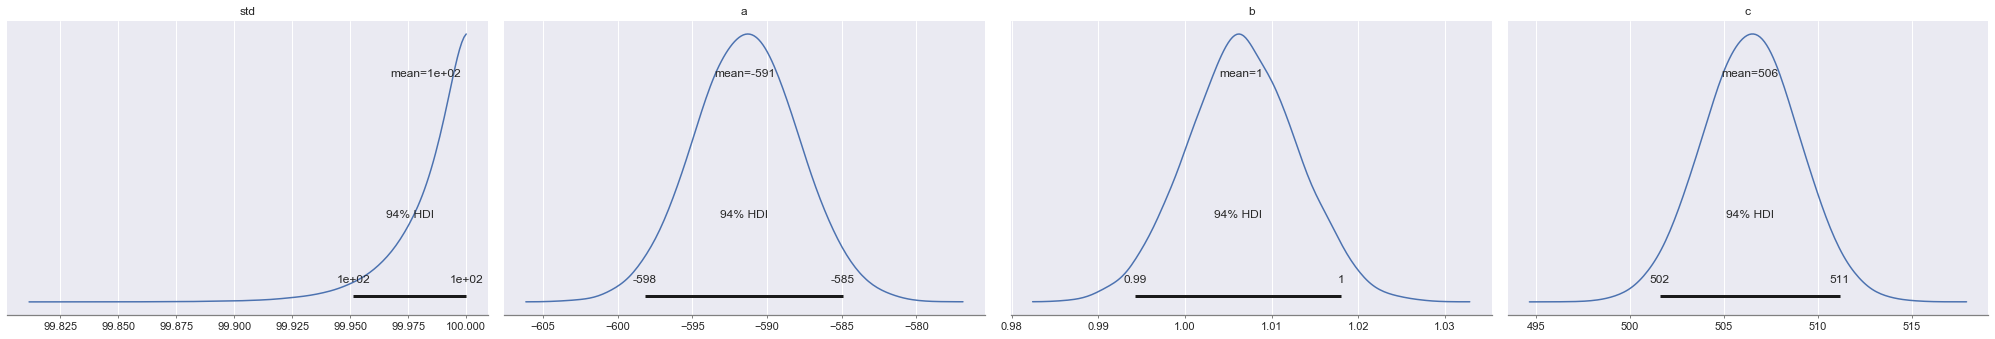

In [99]:
pm.plot_posterior(burned_trace, varnames=["std", "a", "b",'c'])

In [100]:
std_trace = burned_trace['std']
a_trace = burned_trace['a']
b_trace = burned_trace['b']
c_trace = burned_trace['c']

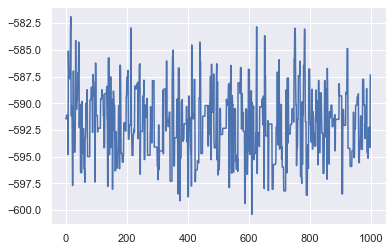

In [101]:
pd.Series(a_trace[:1000]).plot()

In [102]:
std_mean = std_trace.mean()
a_mean = a_trace.mean()
b_mean = b_trace.mean()
c_mean = c_trace.mean()
std_mean, a_mean, b_mean, c_mean

(99.9827192638915, -591.4616715289899, 1.0064954662446066, 506.37785220698527)

In [103]:
params

array([-591.47320253,    1.00647232,  506.37233919])

In [104]:
y_fit_ba = sin_func(x_data, a_mean, b_mean, c_mean)

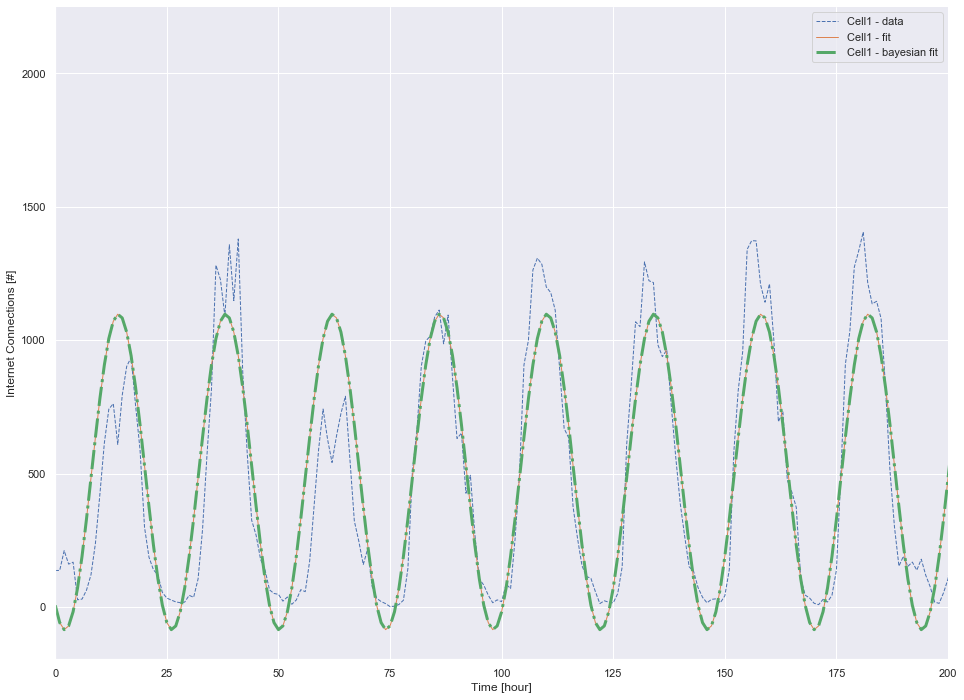

In [106]:
f = plt.figure(figsize=(16,12))
plt.plot(x_data, y_data, linewidth=1, linestyle='--', label='Cell1 - data')
plt.plot(x_data, y_fit, linewidth=1, label='Cell1 - fit')
plt.plot(x_data, y_fit_ba, linewidth=3, label='Cell1 - bayesian fit', linestyle='-.')
plt.xlabel("Time [hour]")
plt.ylabel("Internet Connections [#]")
plt.xlim(0,200)
plt.legend()
sns.despine()
plt.show()